In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy import constants

In [2]:
%matplotlib widget

## Rs with real kep

In [3]:
res_prefix = 'rs_realkep_results'

### Some functions

In [4]:
def rel_kep(r_au, Mstar, inclination):  
        G_grav = constants.G.value
        M_sun = constants.M_sun.value      
        v_kmps = (np.sqrt((G_grav*Mstar*M_sun)/(r_au*1.496e11)))/(np.sin(inclination** np.pi / 180.0)*1.0e3)
        return v_kmps

In [5]:
def log_likelihood(params, Y1, Y2, s1, s2, model):
    
    lg_N, T = params
    N = 10**lg_N     # We convert lg_N back to N


    # Y1 --> Tb(3-2), Y2 --> Tb(2-1)
    Y1_predicted = model.get_intensity(line = 'c18o', Ju = 3, Ncol = N, Tex = T, delv = 0.5, Xconv = 1.e-7)
    Y2_predicted = model.get_intensity(line = 'c18o', Ju = 2, Ncol = N, Tex = T, delv = 0.5, Xconv = 1.e-7)


    #print(f" Y1 = {Y1:.1f}, Y1_pred = {Y1_predicted:.1f}")
    # Compute the log likelihood using normal distributions
    log_likelihood_Y1 = -0.5 * (np.log(2 * np.pi * s1**2) + (Y1 - Y1_predicted)**2 / s1**2)
    log_likelihood_Y2 = -0.5 * (np.log(2 * np.pi * s2**2) + (Y2 - Y2_predicted)**2 / s2**2)
    
    lg_l = log_likelihood_Y1 + log_likelihood_Y2
    return lg_l

In [6]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e16, Ncol[1], 1.e19]) # cm^-2  
    Texes = np.array([5, Texe[1], 30]) # K
    dv = 0.5

    fig, ax = model.makegrid(lines = 'c18o', J1 = 3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, Xconv = 1.e-7, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []

    for nc in Ncol:
        for te in Texe:
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc, Tex =te, delv = dv, Xconv=1.e-7))

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    
    for nc in Ncol:
        for te in Texe:
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc, Tex = te, delv = dv, Xconv=1.e-7))
    
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    ax.scatter(tb7, tb6, color = 'red', marker = 'o', s=50, facecolors='none', 
               edgecolors='r', label = 'Observed')
    
    plt.legend(prop={'size': 6})

    return fig, ax

### Temperature estimation 

#### Read the Data

In [7]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [8]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = None, get_surrounding_pix = False, mode='func',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = None, get_surrounding_pix = False, mode='func',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})

#### Data Visualization

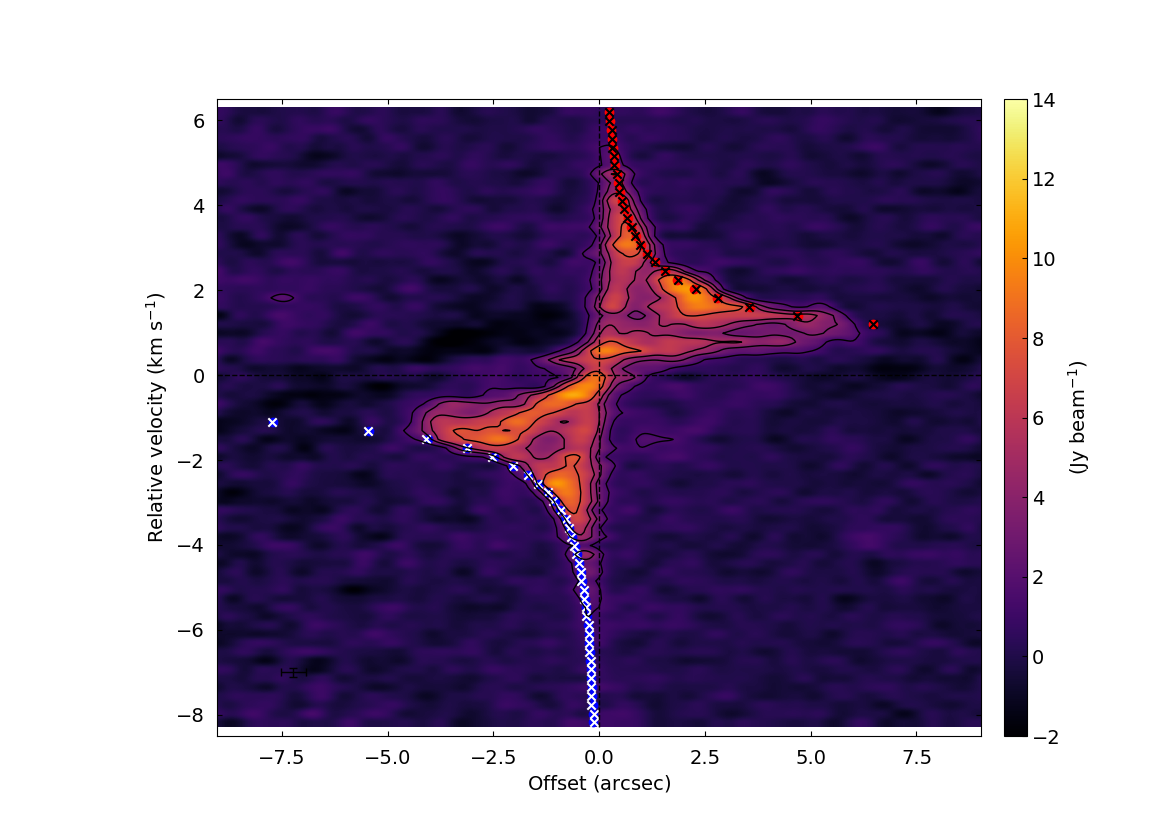

In [9]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)

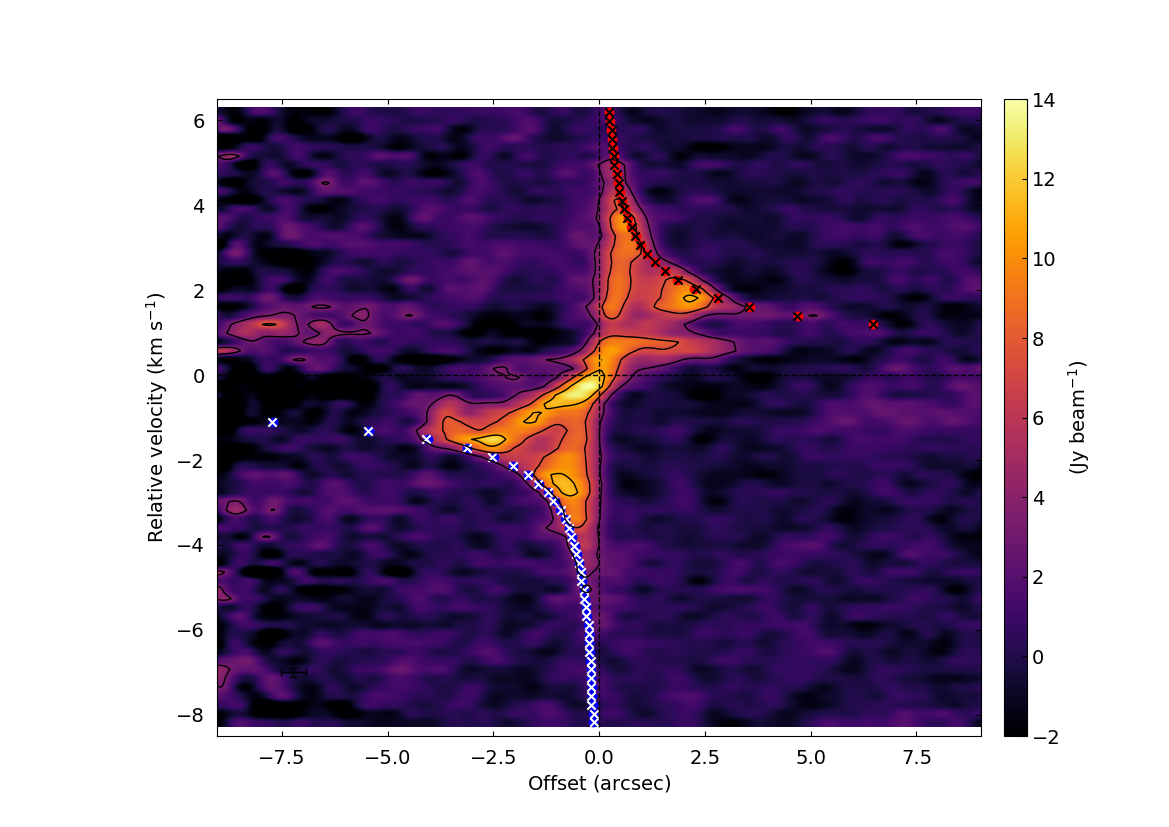

In [10]:
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### Loop over points for T estimation

In [11]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

In [12]:
Texe_rs_rlkep = []
Texe_upq_rlkep = []
Texe_lq_rlkep = []

Ncol_rs_rlkep = []
Ncol_upq_rlkep = []
Ncol_lq_rlkep = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [10.,22.]
T_bounds = [5.,100.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])

op_dir_label = "blueshifted_points_rlkep"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"], Tb_df_b6["Tb_on_point_rs"], 
                          pv_b6.r_as_rs, pv_b6.v_rot_blueshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.01**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                     estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                     bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                     initial_scatter = 10, args= None,
                                     nwalkers = 50, n_steps = 10000, burn_in = 1000, thin_by = 50, return_flat= True,
                                     intensity_model = lte_model, plot_chain = True, 
                                     r_v_info = [str(round(r,3)), str(round(v,2))], 
                                     chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                     show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_rlkep.append(T_qtls[0])
    Texe_rs_rlkep.append(T_qtls[1])
    Texe_upq_rlkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_rlkep.append(Ncol_qtls[0])
    Ncol_rs_rlkep.append(Ncol_qtls[1])
    Ncol_upq_rlkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=None, 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


estimating for r = -1.093e-01 arcsec, v = -8.18 Kmps , Tb7 = 0.4, Tb6 = 0.9


100%|██████████| 10000/10000 [00:29<00:00, 343.55it/s]


estimating for r = -1.151e-01 arcsec, v = -7.97 Kmps , Tb7 = 0.3, Tb6 = 0.5


100%|██████████| 10000/10000 [00:29<00:00, 344.82it/s]


estimating for r = -1.214e-01 arcsec, v = -7.76 Kmps , Tb7 = -0.0, Tb6 = 0.0


100%|██████████| 10000/10000 [00:29<00:00, 339.19it/s]


estimating for r = -1.281e-01 arcsec, v = -7.55 Kmps , Tb7 = 1.0, Tb6 = 0.2


100%|██████████| 10000/10000 [00:29<00:00, 339.33it/s]


estimating for r = -1.355e-01 arcsec, v = -7.35 Kmps , Tb7 = 1.6, Tb6 = 1.3


100%|██████████| 10000/10000 [00:29<00:00, 339.96it/s]


estimating for r = -1.435e-01 arcsec, v = -7.14 Kmps , Tb7 = 1.3, Tb6 = 0.4


100%|██████████| 10000/10000 [00:45<00:00, 218.21it/s]


estimating for r = -1.523e-01 arcsec, v = -6.93 Kmps , Tb7 = 1.3, Tb6 = 1.0


100%|██████████| 10000/10000 [00:29<00:00, 337.46it/s]


estimating for r = -1.619e-01 arcsec, v = -6.72 Kmps , Tb7 = 0.4, Tb6 = 0.5


100%|██████████| 10000/10000 [00:29<00:00, 342.47it/s]


estimating for r = -1.724e-01 arcsec, v = -6.51 Kmps , Tb7 = 0.1, Tb6 = 0.3


100%|██████████| 10000/10000 [00:29<00:00, 342.48it/s]


estimating for r = -1.840e-01 arcsec, v = -6.30 Kmps , Tb7 = 0.7, Tb6 = 1.2


100%|██████████| 10000/10000 [00:28<00:00, 347.55it/s]


estimating for r = -1.968e-01 arcsec, v = -6.10 Kmps , Tb7 = 1.9, Tb6 = 1.2


100%|██████████| 10000/10000 [00:30<00:00, 332.81it/s]


estimating for r = -2.110e-01 arcsec, v = -5.89 Kmps , Tb7 = 1.8, Tb6 = 1.1


100%|██████████| 10000/10000 [00:30<00:00, 331.70it/s]


estimating for r = -2.267e-01 arcsec, v = -5.68 Kmps , Tb7 = 2.6, Tb6 = 1.5


 99%|█████████▉| 9948/10000 [00:30<00:00, 321.77it/s]

In [ ]:
# Calculate errorbars

T_err_rlkep_rs = [np.array(Texe_rs_rlkep)-np.array(Texe_lq_rlkep),np.array(Texe_upq_rlkep)-np.array(Texe_rs_rlkep)] #[tl,tu] for tl,tu in zip(

N_err_rlkep_rs = [np.array(Ncol_rs_rlkep)-np.array(Ncol_lq_rlkep), np.array(Ncol_upq_rlkep)-np.array(Ncol_rs_rlkep)]

In [ ]:
results_data = {"r_rlkep_rs": pv_b6.r_as_rs,
        "Tb7_rlkep_rs" : Tb_df_b7["Tb_on_point_rs"], "Tb6_rlkep_rs" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_rlkep" : Texe_rs_rlkep, "Texe_err_rs_rlkep" : np.array(T_err_rlkep_rs).T.tolist(),
        "Ncol_rs_rlkep" : Ncol_rs_rlkep, "Ncol_err_rs_rlkep" : np.array(N_err_rlkep_rs).T.tolist()
        }
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

#### Visualize results

26 26


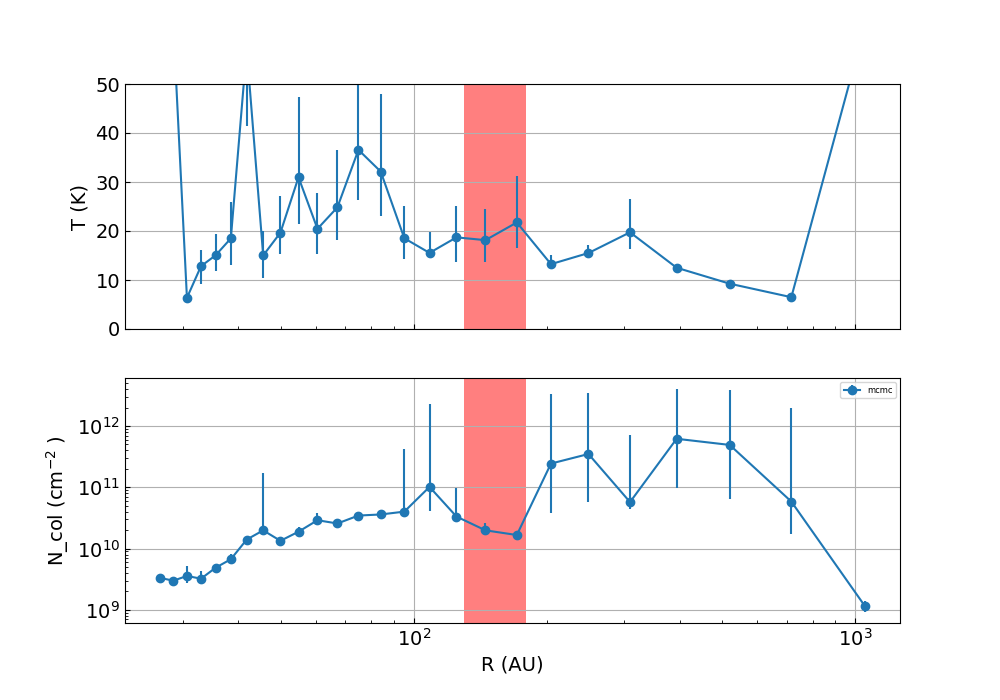

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]
ftd_r_as_rs, ftd_Texe_rs_rlkep, ftd_Terr_rs_rlkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_rlkep, np.array(T_err_rlkep_rs).T.tolist) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

print(len(pv_b6.r_as_rs*140.), len(Texe_rs_rlkep))
axes[0].errorbar(ftd_r_as_rs*140., ftd_Texe_rs_rlkep, yerr=np.array(ftd_Terr_rs_rlkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs, ftd_Ncol_rs_rlkep, ftd_N_err_rs_rlkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_rlkep, np.array(N_err_rlkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(ftd_r_as_rs*140., np.array(Ncol_rs_rlkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_rlkep).T*N_conv_fraction, marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

#### Data acquisition

In [ ]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b6.read_pv(print_details = True)



In [ ]:
# define fix r points
# Get equidistance points

r_au_rlkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_rlkep_rs_fix_r = -r_au_rlkep_rs_fix_r
Mstar = 1.6 # in units of solar mass

v_rot_rlkep_rs_fix_r = rel_kep(r_au=r_au_rlkep_rs_fix_r, Mstar=Mstar, inclination=73.)
v_rot_rlkep_rs_fix_r = - v_rot_rlkep_rs_fix_r

plot_points = [r_au_rlkep_rs_fix_r, v_rot_rlkep_rs_fix_r, r_au_rlkep_rs_fix_r, v_rot_rlkep_rs_fix_r]

In [ ]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, get_surrounding_pix = False, mode='vals',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, get_surrounding_pix = False, mode='vals',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})

#### Data Visualization

In [ ]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### Loop over points for T estimation

In [ ]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

In [ ]:
Texe_rs_rlkep_fix_r = []
Texe_upq_rlkep_fix_r = []
Texe_lq_rlkep_fix_r = []

Ncol_rs_rlkep_fix_r = []
Ncol_upq_rlkep_fix_r = []
Ncol_lq_rlkep_fix_r = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [10.,22.]
T_bounds = [5.,100.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])

op_dir_label = "redshifted_points_rlkep_fix_r"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"], Tb_df_b6["Tb_on_point_rs"], 
                          pv_b6.r_as_rs, pv_b6.v_rot_blueshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                     estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                     bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                     initial_scatter = 10, args= None,
                                     nwalkers = 50, n_steps = 10000, burn_in = 1000, thin_by = 50, return_flat= True,
                                     intensity_model = lte_model, plot_chain = True, 
                                     r_v_info = [str(round(r,3)), str(round(v,2))], 
                                     chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                    "chains",op_dir_label),
                                     show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_rlkep_fix_r.append(T_qtls[0])
    Texe_rs_rlkep_fix_r.append(T_qtls[1])
    Texe_upq_rlkep_fix_r.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_rlkep_fix_r.append(Ncol_qtls[0])
    Ncol_rs_rlkep_fix_r.append(Ncol_qtls[1])
    Ncol_upq_rlkep_fix_r.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=None, 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [ ]:
# Calculate errorbars

T_err_rlkep_rs_fix_r = [np.array(Texe_rs_rlkep_fix_r)-np.array(Texe_lq_rlkep_fix_r),
                         np.array(Texe_upq_rlkep_fix_r)-np.array(Texe_rs_rlkep_fix_r)] 

N_err_rlkep_rs_fix_r = [np.array(Ncol_rs_rlkep_fix_r)-np.array(Ncol_lq_rlkep_fix_r), 
                         np.array(Ncol_upq_rlkep_fix_r)-np.array(Ncol_rs_rlkep_fix_r)]

In [ ]:
results_data_fix_r = {"r_rlkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_rlkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"], "Tb6_rlkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_rlkep_fix_r" : Texe_rs_rlkep_fix_r, "Texe_err_rs_rlkep_fix_r" : np.array(T_err_rlkep_rs_fix_r).T.tolist(),
        "Ncol_rs_rlkep_fix_r" : Ncol_rs_rlkep_fix_r, "Ncol_err_rs_rlkep_fix_r" : np.array(N_err_rlkep_rs_fix_r).T.tolist()
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")

if not os.path.exists(res_path):

        empty_df = pd.DataFrame()
        empty_df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_data_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

#### Visualize results

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]
ftd_r_as_rs_fix_r, ftd_Texe_rs_rlkep_fix_r, ftd_Terr_rs_rlkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_rlkep_fix_r, np.array(T_err_rlkep_rs_fix_r).T.tolist())
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

print(len(pv_b6.r_as_rs*140.), len(Texe_rs_rlkep_fix_r))
axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_rlkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_rlkep_fix_r).T, marker='o', label = 'mcmc')

axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs_fix_r, ftd_Ncol_rs_rlkep_fix_r, ftd_N_err_rs_rlkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_rlkep_fix_r, np.array(N_err_rlkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(Ncol_rs_rlkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_rlkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')